# validating $p(z | photometry)$ for ELAsTiCC

_Alex Malz (GCCL@RUB)_

The goal here is to validate realistically complex mock photo-$z$ posteriors for host galaxies. 

In [2]:
import bisect
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
random.seed = 42
import scipy.stats as sps
import sys
eps = sys.float_info.epsilon

In [3]:
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling, ShiftBounds
from pzflow.distributions import Uniform, Joint, Normal

/global/u2/a/aimalz/ve3_elasticc/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/global/u2/a/aimalz/ve3_elasticc/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [4]:
import qp

## the hostlibs

In [5]:
hl_heads = {'SNIa': 19,
            'SNII': 19, 
            'SNIbc': 19, 
            'UNMATCHED_KN_SHIFT': 19,
            'UNMATCHED_COSMODC2': 18}
# next time, do something clever to infer the header lengths, maybe like
# hl_head = int(os.system(f"zcat {in_path} | cat -n | sed -n '/VARNAMES/ {{ p; q }}'  | awk '{{print $1-1}}'"))

let's pick one hostlib for now.

In [6]:
pick_one = 4
which_hl = list(hl_heads.keys())[pick_one]
in_path = '/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/'+which_hl+'_GHOST.HOSTLIB.gz'
# in_path = '/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/sandbox/SNII_GHOST_NOHEADER.HOSTLIB'

this is somewhat slow because the files are ~GB

In [7]:
df = pd.read_csv(in_path, skiprows=hl_heads[which_hl], delimiter=' ', header=1)
# df.set_index('GALID')
nhost = len(df)
# nhost = 100
# df = df[:nhost]

In [49]:
df.columns

Index(['VARNAMES:', 'GALID', 'RA_GAL', 'DEC_GAL', 'ZTRUE', 'u_obs',
       'u_obs_err', 'g_obs', 'g_obs_err', 'r_obs', 'r_obs_err', 'i_obs',
       'i_obs_err', 'z_obs', 'z_obs_err', 'Y_obs', 'Y_obs_err', 'SQRADIUS',
       'a0_Sersic', 'b0_Sersic', 'n0_Sersic', 'w0_Sersic', 'a1_Sersic',
       'b1_Sersic', 'n1_Sersic', 'w1_Sersic', 'a_rot', 'ELLIPTICITY',
       'LOGMASS', 'LOG_SFR', 'OBJID2', 'ZPHOT_Q000', 'ZPHOT_Q010',
       'ZPHOT_Q020', 'ZPHOT_Q030', 'ZPHOT_Q040', 'ZPHOT_Q050', 'ZPHOT_Q060',
       'ZPHOT_Q070', 'ZPHOT_Q080', 'ZPHOT_Q090', 'ZPHOT_Q100', 'logP50', 'IQR',
       'ZPHOT', 'ZPHOT_ERR', 'IQR_ZPHOT', 'P_ZPHOT', 'Unnamed: 48',
       'NBR_LIST'],
      dtype='object')

## forecasting-level photo-z PDFs

using the values from the DESC SRD

### first create likelihood $p(z_{obs} | z_{true})$

using values from [DESC SRD](https://arxiv.org/abs/1809.01669)

In [ ]:
sigma = 0.02

In [ ]:
true_locs = df['ZTRUE'].values.reshape((nhost, 1))

stupid transform because `scipy.stats.truncnorm` assumes input endpoints are given for standard normal and _then_ rescales them to provided mean and standard deviation

In [ ]:
lik_min = (0. - true_locs) / (sigma * (1. + true_locs))
lik_max = (3. - true_locs) / (sigma * (1. + true_locs))
# lik_min = (0-true_locs) / (sigma * (1. + true_locs))
# lik_max = (3-true_locs) / (sigma * (1. + true_locs))

In [ ]:
likelihood = sps.truncnorm(a=lik_min, b=lik_max, loc=true_locs, scale=sigma*(1.+true_locs))
# pseudo_likelihood = sps.truncnorm(a=lik_min, b=lik_max, loc=0., scale=1.)

### then draw point estimate $z_{obs} \sim p(z_{obs} | z_{true})$

warning: this is slow because the endpoints are different -- stupid scipy defaults!

In [ ]:
# pseudo_obs = pseudo_likelihood.rvs(random_state=42)
# obs_locs = pseudo_obs * (sigma * (1. + true_locs)) + true_locs
obs_locs = likelihood.rvs(random_state=42)

check that these make sense

In [ ]:
plt.scatter(true_locs, obs_locs, s=0.1, alpha=0.1)
plt.xlabel('$z_{true}$')
plt.ylabel('$z_{obs}$')
plt.plot([0., 3.], [0., 3.], c='k')

### then make posterior $p(z_{true} | z_{obs})$

this is what photo-z PDF estimators actually produce

sadly have to do the stupid scipy rescaling again

In [ ]:
pos_min = (0. - obs_locs) / (sigma * (1. + obs_locs))
pos_max = (3. - obs_locs) / (sigma * (1. + obs_locs))

In [ ]:
posterior = sps.truncnorm(a=pos_min, b=pos_max, loc=obs_locs, scale=sigma*(1.+obs_locs))

plot a few examples

In [9]:
zgrid = np.logspace(-3., np.log10(3.), 300)
to_plot = random.sample(range(nhost), 10)

NameError: name 'nhost' is not defined

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(5, 20))
for i, galind in enumerate(to_plot):
    example = sps.truncnorm(a=pos_min[galind][0], b=pos_max[galind][0], 
                            loc=obs_locs[galind][0], scale=sigma*(1+obs_locs[galind][0])).pdf(zgrid)
    ax[i].plot(zgrid, example)
    ax[i].vlines(true_locs[galind][0], 0, max(example), color='k', linewidth=.75)
    ax[i].vlines(obs_locs[galind][0], 0, max(example), color='r', linewidth=.75)
    ax[i].set_ylim(0, 15)
    ax[i].text(2, 10, str(df['GALID'].loc[i]))
    ax[i].set_ylabel('$p(z)$')
    if i == len(to_plot)-1:
        ax[i].set_xlabel('$z$')
    else:
        ax[i].set_xticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)

## evaluate quantiles

using regular grid for now but can be optimized depending on science case sensitive to outliers vs. degeneracies vs. general spread

In [ ]:
quants = np.linspace(0., 1., 11)
quants[0] += eps
quants[-1] -= eps

In [ ]:
quantlabs = ['ZPHOT_Q000', 'ZPHOT_Q010', 'ZPHOT_Q020', 'ZPHOT_Q030', 'ZPHOT_Q040', 'ZPHOT_Q050', 'ZPHOT_Q060', 'ZPHOT_Q070', 'ZPHOT_Q080', 'ZPHOT_Q090', 'ZPHOT_Q100']

this step is slow!

In [ ]:
df[quantlabs] = posterior.ppf(quants)

plot one just to see what the quantiles look like for a given PDF

In [ ]:
plot_one = random.sample(range(nhost), 1)
plt.plot(zgrid, sps.truncnorm(a=pos_min[plot_one][0], b=pos_max[plot_one][0], 
                              loc=obs_locs[plot_one][0], scale=sigma*(1+obs_locs[plot_one][0])).pdf(zgrid))
plt.vlines(df[quantlabs].loc[plot_one], -1, 1, linestyle='--', color='k')
# plt.xlim(obs_locs[plot_one][0]-5*sigma*(1+obs_locs[plot_one][0]), 
#          obs_locs[plot_one][0]+5*sigma*(1+obs_locs[plot_one][0]))
plt.xlim(df['ZPHOT_Q000'].loc[plot_one].values[0]-0.01, df['ZPHOT_Q100'].loc[plot_one].values[0]+0.01)
plt.text(obs_locs[plot_one][0], 2, str(df['GALID'].loc[plot_one[0]]))
plt.xlabel('$z$')
plt.ylabel('$p(z)$')

plot histogram of first and last quantile, since these aren't really well-defined

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(df['ZPHOT_Q000'], bins=300)
ax[0].set_xlabel('$z_{0\%}$')
ax[1].hist(df['ZPHOT_Q100'], bins=300)
ax[1].set_xlabel('$z_{100\%}$')

also save $p(z_{median})$ and [inter-quartile range](https://en.wikipedia.org/wiki/Interquartile_range)

unfortunately these are quite slow now!

In [ ]:
df['IQR_ZPHOT'] = posterior.ppf(0.75) - posterior.ppf(0.25)

In [ ]:
df['P_ZPHOT'] = posterior.pdf(posterior.median())

save a file

In [ ]:
out_path = '/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/zquants/'+which_hl+'_dummy_pz.csv'
df.to_csv(out_path, index=False, sep=' ')

## reading in quantiles

In [8]:
idx = 0
which_hl = 'UNMATCHED_KN_SHIFT'
batch_size = 100
batch_factor = 100

In [9]:
glob_path = '/global/cfs/cdirs/lsst/groups/TD/SN/SNANA/SURVEYS/LSST/ROOT/PLASTICC_DEV/HOSTLIB/zquants/'
in_name = 'pz'+which_hl+'batch'+str(idx)+'_'+str(batch_size * batch_factor)+'chunks'+str(batch_size)
in_pdfs = qp.read(glob_path+in_name+'.fits')

In [10]:
nhost = len(in_pdfs.objdata()['locs'])
zgrid = np.logspace(-2.5, np.log10(3.), 250)
to_plot = random.sample(range(nhost), 10)

zgrid_lo = np.logspace(-3., np.log10(3.), 100)
zgrid_hi = np.logspace(-3., np.log10(3.), 300)

In [11]:
evalled = in_pdfs.pdf(zgrid)
evalled_lo = in_pdfs.pdf(zgrid_lo)
evalled_hi = in_pdfs.pdf(zgrid_hi)

/global/u2/a/aimalz/ve3_elasticc/lib/python3.9/site-packages/qp/quant_pdf.py:261: RuntimeWarning: divide by zero encountered in true_divide
  self._valatloc = (self._quants[1:] - self._quants[0:-1])/(self._locs[:,1:] - self._locs[:,0:-1])


(0.0, 1.0)

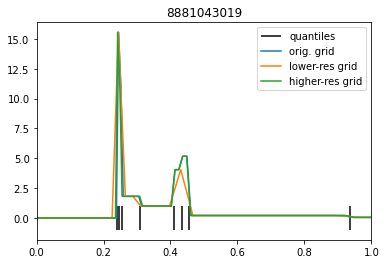

In [13]:
rando = 10
plt.title(str(in_pdfs.ancil['GALID'][rando]))
plt.vlines(in_pdfs.objdata()['locs'][rando], -1, 1, color='k', label='quantiles')
plt.plot(zgrid, evalled[rando], label='orig. grid')
plt.plot(zgrid_lo, evalled_lo[rando], label='lower-res grid')
plt.plot(zgrid_hi, evalled_hi[rando], label='higher-res grid')
plt.legend()
plt.xlim(0, 1)

## reconstructing a pdf from quantiles

read from a generic hostlib file

In [ ]:
df = pd.read_csv(out_path, delimiter=' ', header=0)

pick one for demonstration

In [ ]:
plot_one = random.sample(range(nhost), 1)[0]
zq_vals = df[quantlabs].loc[plot_one].values

This is the reconstruction algorithm from [ye olde qp](https://github.com/aimalz/qp/blob/master/qp/pdf.py#L554).

Note: The aforementioned code exhibits unexpected behavior in Python 3; 
you must (unfortunately) run it in Python 2 for consistency with [Malz & Marshall+ 2017](http://stacks.iop.org/1538-3881/156/i=1/a=35).

Another note: You can save yourself one float by replacing the redshifts where $CDF=0$ and $CDF=1$ with $p(z_{q})$ for any of the saved quantiles $q$, at the cost of some inaccuracy in the tails.

In [ ]:
# derivative = (quants[1:] - quants[:-1]) / (zq_vals[1:] - zq_vals[:-1])
# derivative = np.insert(derivative, 0, 0.)
# derivative = np.append(derivative, 0.)

# def pdf_inside(zgrid):
#     pdf = np.zeros_like(zgrid)
#     for n in range(len(zgrid)):
#         ind = bisect.bisect_left(zq_vals, zgrid[n])
#         pdf[n] = derivative[ind]
#     return(pdf)

q = quants
z = zq_vals

derivative = (q[1:] - q[:-1]) / (z[1:] - z[:-1])
derivative = np.insert(derivative, 0, eps)
derivative = np.append(derivative, eps)
def pdf_inside(xf):
    nx = len(xf)
    yf = np.ones(nx) * eps
    for n in range(nx):
        i = bisect.bisect_left(z, xf[n])
        yf[n] = derivative[i]
    return(yf)

eval_pdf = pdf_inside(zgrid)

show difference between original and reconstruction

In [ ]:
plt.plot(zgrid, sps.truncnorm(a=pos_min[plot_one][0], b=pos_max[plot_one][0], 
                              loc=obs_locs[plot_one][0], scale=sigma*(1+obs_locs[plot_one][0])).pdf(zgrid),
                              label='original PDF')
plt.vlines(df[quantlabs].loc[plot_one], -1, 1, linestyle='--')
plt.xlim(zq_vals[0] - 0.01, zq_vals[-1] + 0.01)
plt.plot(zgrid, eval_pdf, label='reconstructed from '+str(len(quants))+' quantiles')
plt.text(obs_locs[plot_one][0], 2, str(df['GALID'].loc[plot_one]))
plt.legend(loc='upper right')
plt.xlabel('$z$')
plt.ylabel('$p(z)$')

## examining point estimates

In [14]:
df_subset = df[df['GALID'].isin(in_pdfs.ancil['GALID'])]

In [15]:
truth = df_subset['ZTRUE'].to_numpy()

In [16]:
medians = in_pdfs.objdata()['locs'][:, 4]

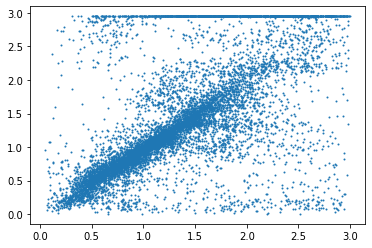

In [17]:
plt.scatter(truth, medians, s=1)#, cmap=mpl.cm.viridis_r, c=scatter/(1+medians), vmin=0., vmax=max(scatter/(1+medians)))
# plt.colorbar()

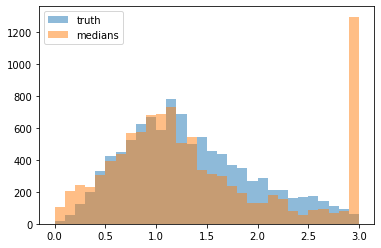

In [18]:
plt.hist(truth, alpha=0.5, label='truth', bins=np.arange(0., 3.01, 0.1));
plt.hist(medians, alpha=0.5, label='medians', bins=np.arange(0., 3.01, 0.1));
plt.legend()

## evaluating point estimate metrics

In [19]:
bias_mlg = (medians - truth) / (1 + medians)
bias_desc = (medians - truth) / (1 + truth)

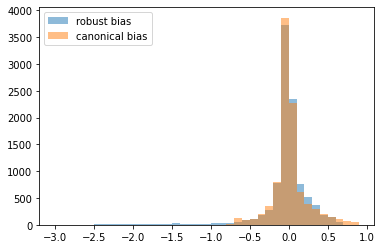

In [20]:
plt.hist(bias_mlg, bins=np.arange(-3., 1., 0.1), alpha=0.5, label='robust bias');
plt.hist(bias_desc, bins=np.arange(-3., 1., 0.1), alpha=0.5, label='canonical bias');
plt.legend()

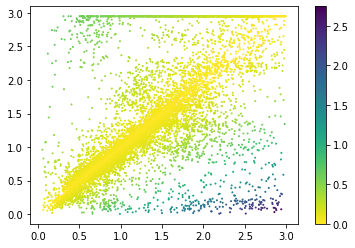

In [21]:
plt.scatter(truth, medians, s=1, cmap=mpl.cm.viridis_r, c=np.abs(bias_mlg), vmin=0, vmax=max(np.abs(bias_mlg)))
plt.colorbar()

In [22]:
scatter_mlg = in_pdfs.ancil['iqr'][:,0] * 1.349
scatter_desc = scatter_mlg / (1 + truth)

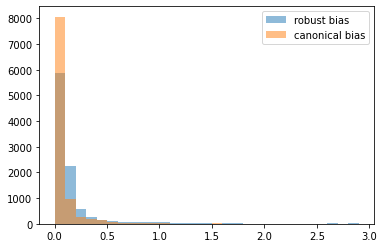

In [23]:
plt.hist(scatter_mlg, bins=np.arange(0., 3., 0.1), alpha=0.5, label='robust bias');
plt.hist(scatter_desc, bins=np.arange(0., 3., 0.1), alpha=0.5, label='canonical bias');
plt.legend()
# plt.semilogx()

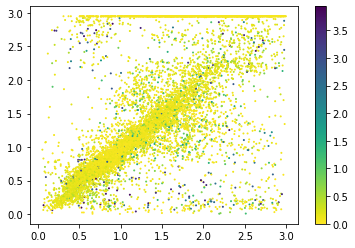

In [25]:
plt.scatter(truth, medians, s=1, cmap=mpl.cm.viridis_r, c=scatter_mlg, vmin=0, vmax=max(scatter_mlg))
plt.colorbar()

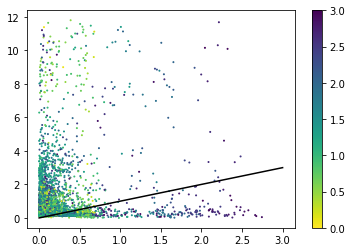

In [26]:
plt.scatter(np.abs(bias_mlg), 3. * scatter_mlg, s=1, cmap=mpl.cm.viridis_r, c=truth, vmin=0, vmax=3)
plt.plot([0, 3], [0, 3], c='k')
plt.colorbar()

In [27]:
thresh = np.where(3 * scatter_mlg < 0.06, 0.06, 3 * scatter_mlg)

In [28]:
is_outlier = np.where(np.abs(bias_mlg) > thresh)[0]

In [29]:
len(is_outlier)

1728

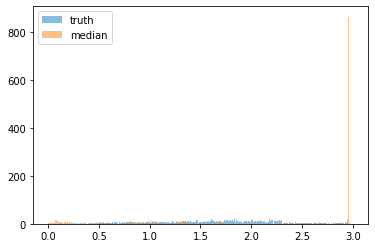

In [45]:
plt.hist(truth[is_outlier], bins=np.arange(0., 3.01, 0.01), alpha=0.5, label='truth');
plt.hist(medians[is_outlier], bins=np.arange(0., 3.01, 0.01), alpha=0.5, label='median');
plt.legend()

In [58]:
np.max(medians[is_outlier])

2.9511211555778787

## Troubleshooting

In [30]:
hl_df = df_subset.rename(columns={'ZTRUE':'redshift',
                           'Y_obs':'y', 
                           'r_obs':'r', 
                           'u_obs':'u', 
                           'g_obs':'g', 
                           'z_obs':'z', 
                           'i_obs':'i',#})[['redshift','u', 'g', 'r', 'i', 'z', 'y']]
                            'Y_obs_err':'y_err', 
                           'r_obs_err':'r_err', 
                           'u_obs_err':'u_err', 
                           'g_obs_err':'g_err', 
                           'z_obs_err':'z_err', 
                           'i_obs_err':'i_err'})[['redshift', 
                                                  'u', 'g', 'r', 'i', 'z', 'y', 
                                                  'u_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err']]

quantities = hl_df.columns

hl_df_colors = hl_df.copy()[['redshift', 'r', 'r_err']]
for i in range(len(quantities)-2-6):
    hl_df_colors[quantities[i+1]+'-'+quantities[i+2]] = hl_df[quantities[i+1]] - hl_df[quantities[i+2]]
    hl_df_colors[quantities[i+1]+'-'+quantities[i+2]+'_err'] = np.sqrt(hl_df[quantities[6+i+1]]**2 + hl_df[quantities[6+i+2]]**2)
print(hl_df_colors.columns)

# hl_df = hl_df_colors[['redshift', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r', 'u-g_err', 'g-r_err', 'r-i_err', 'i-z_err', 'z-y_err', 'r_err']][:nhost]

Index(['redshift', 'r', 'r_err', 'u-g', 'u-g_err', 'g-r', 'g-r_err', 'r-i',
       'r-i_err', 'i-z', 'i-z_err', 'z-y', 'z-y_err'],
      dtype='object')


In [31]:
flow = Flow(file='../data_files/model_photo-zs_uniform_splbin64_epoch100_flow.pkl')
# this path will not change any time soon
flow.latent = Uniform((-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5), (-5, 5))

In [33]:
hl_df_colors.iloc[is_outlier[0]]

redshift     1.585400
r           26.193600
r_err        0.098500
u-g         -0.122800
u-g_err      0.556113
g-r         -0.173900
g-r_err      0.133763
r-i         -0.138000
r-i_err      0.192079
i-z         -0.131500
i-z_err      0.398790
z-y          0.167200
z-y_err     26.481489
Name: 10, dtype: float64

In [35]:
flow_z = flow.posterior(hl_df_colors.iloc[is_outlier],#[['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'r']], 
                            column='redshift', grid=zgrid, err_samples=10)#, batch_size=min(batch_size, len(hl_subset)))

In [37]:
flow_z.shape

(10, 250)

In [71]:
zgrid

array([0.00316228, 0.00325055, 0.00334128, 0.00343454, 0.00353041,
       0.00362895, 0.00373025, 0.00383437, 0.0039414 , 0.00405142,
       0.0041645 , 0.00428075, 0.00440023, 0.00452306, 0.00464931,
       0.00477908, 0.00491248, 0.0050496 , 0.00519055, 0.00533544,
       0.00548436, 0.00563745, 0.0057948 , 0.00595655, 0.00612282,
       0.00629372, 0.0064694 , 0.00664998, 0.0068356 , 0.0070264 ,
       0.00722253, 0.00742413, 0.00763136, 0.00784437, 0.00806333,
       0.0082884 , 0.00851976, 0.00875757, 0.00900202, 0.00925329,
       0.00951157, 0.00977707, 0.01004998, 0.0103305 , 0.01061885,
       0.01091526, 0.01121993, 0.01153311, 0.01185504, 0.01218594,
       0.01252609, 0.01287573, 0.01323513, 0.01360456, 0.0139843 ,
       0.01437464, 0.01477588, 0.01518832, 0.01561227, 0.01604805,
       0.016496  , 0.01695645, 0.01742975, 0.01791627, 0.01841636,
       0.01893042, 0.01945882, 0.02000197, 0.02056028, 0.02113418,
       0.0217241 , 0.02233048, 0.02295379, 0.02359449, 0.02425

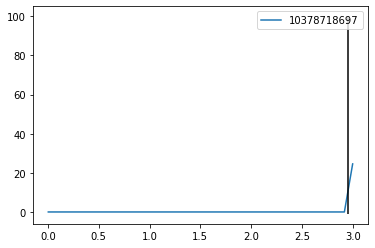

In [70]:
for i in [7]:
    plt.plot(zgrid, flow_z[i], label=df_subset['GALID'].iloc[i])
# for i in range(10):
#     plt.vlines(df_subset['ZTRUE'].iloc[i], -1., 100)
    plt.vlines(medians[is_outlier[i]], -1., 100, color='k')
plt.legend()